

# Proyecto

### Equipo:

- Gonzalo Claro
- Camilo Meneses

- Usuario: peor_es_nah

- Team name: es trabajo honesto

### [Link de repositorio de GitHub](https://github.com/GonzaloClaro/evaluaciones_mds7202_grupo23)



## 1. Introducción

El objetivo de este proyecto consiste en aplicar todos los conocimientos adquiridos a lo largo del semestre (preparación de datos, EDA, preprocesamiento, feature engineering, pipelines, clasificación y regresión, optimización de modelos, etc) con la finalidad de solucionar 2 problemas distintos: 

1. **Clasificación de potenciales evaluaciones con las que los consumidores evaluarán las películas**. Las posibles clases que deben asignar a cada película son `('Negative', 'Mixed', 'Mostly Positive', 'Positive', 'Very Positive')`. Donde la métrica de evaluación utilizada para medir la clasificación es `f1_macro`, la cual se calcula utilizando la media aritmética de todos los f1-score por clase. Este método trata todas las clases por igual, independientemente al número de ocurrencias reales de la clase en el dataset. En nuestro caso, estamos trabajando con un conjunto de datos desbalanceado donde todas las clases son igualmente importantes, por lo que usar f1-macro es una buena opción, ya que trata a todas las clases por igual.

2. **Regresión de los potenciales ingresos que tendrán las películas**. La métrica de evaluación utilizada para medir la clasificación es `r_2`. R2 es el porcentaje de la variación en la variable de respuesta que es explicado por un modelo lineal, por lo que a mayores valores de R2 se tiende a pensar que el modelo se ajusta mejor a los datos. Se recomienda ver el gráfico de residuos para corroborar que no haya overfitting. Se escoge esta métrica por su sencillez de interpretación y robustez. 

Para ello contamos con un dataset con información de 6451 películas, más las etiquetas de las clases y los valores a predecir. Se cuenta tanto con variables numéricas (como la duración o el presupuesto de la película) y variables de texto (como el título de la película, los actores, la productora, la descripción, etc).

Se realizaron transformaciones en los datos como contar ciertos valores (ej: cantidad de actores), generar distintos ratios (presupuesto por cantidad de actores, cantidad de actores por la duracion de la pelicula, presupuesto por la duración de la película), se vectorizaron textos, se obtuvieron valores representativos para cada película si es que sus actores eran parte de los actores más populares, o si fueron realizados por productoras populares, etc.

Nuestra propuesta para resolver el problema consistió en modelo de clasificación basado en LGBMClassifier con hiperparámetros de (num_leaves=50, objective='multiclass') encontrados mediante GridSearchCV y un modelo de regresión basado en XGBRegressor con hiperparámetros (colsample_bytree=0.7, learning_rate=0.03, min_child_weight=4, n_estimators=200, silent=1, subsample=0.7) encontrados mediante GridSearchCV.

Los modelos encontrados no cumplieron las expectativas, pero se estuvo muy cerca del baseline.

---
## 2. Prepración y Análisis Exploratorio de Datos

### Librerías

In [1]:
import pandas as pd
!pip3 install pickle5
import pickle5 as pickle
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import matplotlib.pyplot as plt
import missingno as msno
!pip install umap-learn
from umap import UMAP
import numpy as np
import seaborn as sns
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.dummy import DummyRegressor
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import LinearRegression
import xgboost as xg
import lightgbm as lgb
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 256 kB 4.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 2.6 MB/s 
     |████████████████████████████████| 1.1 MB 16.9 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=ee7127de456b74453b62e8777236869097d00991e04bcdde00715abd872ad15e
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=878e4bd7b627950d909e39aa80abb68d59c8e10cb885bb7002bfe9b17906acf6
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Importamos datos

In [2]:
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/Othercomputers/Camilo!/Universidad/Laboratorio de Programación Científica para Ciencia de Datos/Proyecto/Archivos/"

Mounted at /content/drive


In [3]:
# Cargamos los datos.

train_numerical = pd.read_parquet(path+"train_numerical_features.parquet")
train_text = pd.read_parquet(path+"train_text_features.parquet")
with open(path+"test.pickle", "rb") as fh:
  test = pickle.load(fh)

### Prepración de datos

In [4]:
# Fusionamos por id.

compartidas = set(train_text.columns)&set(train_numerical.columns) #columnas compartidas
compartidas.remove('id') #sacamos id para hacer la intersección
n_numerical = train_numerical.drop(columns=compartidas) #train_numerical sin las columnas compartidas
df = pd.merge(left=n_numerical, right=train_text, on="id", how="inner",sort=True) #unimos mediante la intersección

In [5]:
# Eliminar columnas 'poster_path', 'backdrop_path', 'recommendations'.

df = df.drop(columns=['poster_path', 'backdrop_path', 'recommendations'])

In [6]:
# Filtrar ejemplos con revenue igual a 0.

df = df[df['revenue']!=0]

In [7]:
# Filtrar ejemplos con release_date y runtime nulos.

df = df.dropna(subset=["release_date","runtime"])

In [8]:
# Convertir fechas de release_date a pd.DateTime.

df['release_date'] = pd.to_datetime(df.release_date)

In [9]:
# Conservar solo los ejemplos con status "Released".

df = df[df['status']=="Released"]

In [10]:
# Rellenar valores nulos categóricos y de texto con ''.

df = df.fillna('')

In [11]:
# Discretizar vote_average y guardar los resultados en la columna label.

bins = [0, 5, 6, 7, 8, 10]
labels = ['Negative','Mixed','Mostly Positive','Positive','Very Positive']
df['label'] = pd.cut(df['vote_average'],bins=bins,labels=labels)

In [12]:
# Eliminar la columna vote_average e id.

df = df.drop(columns=['vote_average','id'])

In [13]:
# Renombrar la columna revenue por target.

df = df.rename(columns = {'revenue':'target'})

In [14]:
# Reseteamos indices.

df = df.reset_index(drop=True)

### Análisis exploratorio de datos

In [15]:
# Descripción general del dataset.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6451 entries, 0 to 6450
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   budget                6451 non-null   float64       
 1   target                6451 non-null   float64       
 2   runtime               6451 non-null   float64       
 3   status                6451 non-null   object        
 4   title                 6451 non-null   object        
 5   genres                6451 non-null   object        
 6   original_language     6451 non-null   object        
 7   overview              6451 non-null   object        
 8   production_companies  6451 non-null   object        
 9   release_date          6451 non-null   datetime64[ns]
 10  tagline               6451 non-null   object        
 11  credits               6451 non-null   object        
 12  keywords              6451 non-null   object        
 13  label             

In [16]:
#Vemos valores duplicados

df[df.duplicated(keep=False)]

,budget,target,runtime,status,title,genres,original_language,overview,production_companies,release_date,tagline,credits,keywords,label


In [17]:
# Métricas resumen de variables numéricas.

df.describe()

,budget,target,runtime
count,6.451000e+03,6.451000e+03,6451.000000
mean,2.986470e+07,9.258012e+07,108.843590
std,4.180378e+07,1.756207e+08,20.173254
min,0.000000e+00,1.000000e+00,4.000000
25%,2.600000e+06,7.937442e+06,95.000000
50%,1.500000e+07,3.142933e+07,105.000000
75%,3.900000e+07,9.822657e+07,119.000000
max,3.800000e+08,2.847246e+09,366.000000


In [18]:
df[df.runtime<30]

,budget,target,runtime,status,title,genres,original_language,overview,production_companies,release_date,tagline,credits,keywords,label
3061,300000.0,123967.0,5.0,Released,Tin Toy,Animation-Family,en,Babies are hardly monster-like unless you're a...,Pixar-Buena Vista Pictures,1988-08-01,,Sárközi Olivér,baby-short film-cgi animation,Mostly Positive
3062,0.0,123967.0,4.0,Released,Knick Knack,Animation-Family-Comedy,en,Life on a shelf as a snowman trapped in a snow...,Pixar,1989-11-23,,,snowman-escape-snowglobes-short film,Positive
3165,3000000.0,21000000.0,26.0,Released,Mickey's Christmas Carol,Family-Animation,en,Ebenezer Scrooge is far too greedy to understa...,Walt Disney Pictures-Walt Disney Productions,1983-10-19,,Alan Young-Wayne Allwine-Clarence Nash-Hal Smi...,cartoon-ghost-charles dickens-christmas,Positive


In [19]:
df[df.budget<10000]

,budget,target,runtime,status,title,genres,original_language,overview,production_companies,release_date,tagline,credits,keywords,label
23,0.0,51001550.0,112.0,Released,Talk to Her,Drama-Romance,es,Two men share an odd friendship while they car...,Vía Digital-Good Machine-El Deseo-Atresmedia,2002-03-15,,Leonor Watling-Rosario Flores-Javier Cámara-Da...,suicide-spain-rape-coma-bullfighting-journalis...,Positive
59,0.0,8945072.0,103.0,Released,"Spring, Summer, Fall, Winter... and Spring",Drama,ko,An isolated lake where an old monk lives in a ...,LJ Film-Korea Pictures-Cineclick Asia-Cinesoul...,2003-09-19,"What you like, others will also like.",Oh Young-soo-Kim Ki-duk-Kim Young-min-Seo Jae-...,buddhism-life and death-philosophy-countryside...,Positive
78,0.0,3803298.0,159.0,Released,Breaking the Waves,Drama-Romance,da,In a small and conservative Scottish village a...,Trust Film-Det Danske Filminstitut,1996-05-13,Love is a mighty power.,Emily Watson-Stellan Skarsgård-Katrin Cartlidg...,underdog-scotland-prostitute-paraplegic-tradit...,Positive
156,0.0,1535558.0,103.0,Released,Live Flesh,Drama-Thriller-Romance,es,A scorned ex-convict forces himself into the l...,France 3 Cinéma-El Deseo-CiBy 2000,1997-10-10,"Life, love, desire... and everything in between.",Javier Bardem-Francesca Neri-Liberto Rabal-Áng...,sexual obsession-prostitute-adultery-adolescen...,Positive
177,0.0,5800000.0,141.0,Released,Rio Bravo,Western,en,The sheriff of a small town in southwest Texas...,Warner Bros. Pictures-Armada Productions,1959-03-17,They fought back to back... No quarter given.....,John Wayne-Dean Martin-Ricky Nelson-Angie Dick...,sheriff-small town-gun-marshal-texas-deputy-mu...,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6443,0.0,12549382.0,106.0,Released,X,Horror-Thriller,en,In 1979 a group of young filmmakers set out to...,A24-Little Lamb Productions-Bron Studios-Mad S...,2022-03-17,Dying to show you a good time.,Mia Goth-Jenna Ortega-Brittany Snow-Martin Hen...,sheriff-1970s-shotgun-gas station-war veteran-...,Mostly Positive
6445,0.0,63501160.0,122.0,Released,Belle,Animation-Drama-Science Fiction-Music,ja,Suzu is a 17-year-old high-school student livi...,Studio Chizu-Nippon Television Network Corpora...,2021-07-16,You are no longer alone.,Kaho Nakamura-Ryo Narita-Shota Sometani-Tina T...,society-friendship-love-slice of life-anime-on...,Positive
6446,0.0,30000000.0,98.0,Released,Belfast,Drama,en,Buddy is a young boy on the cusp of adolescenc...,Northern Ireland Screen-TKBC-Focus Features,2021-11-12,"No matter how far you go, you never forget whe...",Jude Hill-Caitríona Balfe-Jamie Dornan-Judi De...,working class-black and white-belfast north ir...,Positive
6447,0.0,3186865.0,105.0,Released,The Outfit,Crime-Drama-Thriller,en,Leonard is an English tailor who used to craft...,Focus Features-FilmNation Entertainment-Unifie...,2022-02-25,Everyone has something up their sleeve.,Mark Rylance-Johnny Flynn-Zoey Deutch-Dylan O'...,chicago illinois-murder-organized crime-mobste...,Positive


In [20]:
df[df.target<10000]

,budget,target,runtime,status,title,genres,original_language,overview,production_companies,release_date,tagline,credits,keywords,label
135,18000.0,8811.0,77.0,Released,The Cabinet of Dr. Caligari,Drama-Horror-Thriller-Crime,de,Francis a young man recalls in his memory the ...,Decla Film Gesellschaft Holz & Co.,1920-02-27,You must become Caligari!,Werner Krauß-Conrad Veidt-Friedrich Fehér-Lil ...,insane asylum-black and white-cult film-silent...,Positive
246,2500000.0,7235.0,117.0,Released,The Idiots,Comedy-Drama,da,With his first Dogma-95 film director Lars von...,Zentropa Entertainments-DR TV,1998-04-28,Society is the mother of all Idiots.,Bodil Jørgensen-Jens Albinus-Anne Louise Hassi...,mentally disabled-lifestyle-commune-test of co...,Mostly Positive
924,0.0,1457.0,191.0,Released,Children of Paradise,Drama-Romance,fr,Filmed during the German occupation this Frenc...,Société Nouvelle Pathé Cinéma,1945-03-15,AT LAST! The Celebrated French Film,Arletty-Jean-Louis Barrault-Pierre Brasseur-Ma...,pantomime-anarchist-count-love-thief-murder-mi...,Very Positive
1014,2200000.0,10.0,160.0,Released,Nashville,Drama-Music-Comedy,en,The intersecting stories of twenty-four charac...,Paramount-ABC Entertainment,1975-06-11,The damnedest thing you ever saw.,David Arkin-Barbara Baxley-Ned Beatty-Karen Bl...,country music-music festival-satire-candidate-...,Positive
1188,0.0,3193.0,92.0,Released,Hiroshima Mon Amour,Drama-History-Romance,fr,The deep conversation between a Japanese archi...,Argos Films-Como Films-Daiei Film-Pathé Overse...,1959-06-10,From the measureless depths of a woman's emoti...,Emmanuelle Riva-Eiji Okada-Stella Dassas-Pierr...,france-return-new love-atomic bomb-architect-l...,Positive
1202,0.0,7940.0,63.0,Released,L'Âge d'Or,Romance-Comedy-Drama,fr,The film consists of a series of tightly inter...,Vicomte de Noailles,1930-10-28,A surrealist masterpiece.,Gaston Modot-Lya Lys-Max Ernst-Lionel Salem-Ca...,villa-beach-child murder-orgy-bishop-sculpture...,Mostly Positive
1279,1500000.0,27.0,90.0,Released,Ben X,Drama,nl,Harassed by bullies because of his mild autism...,MMG Film & TV Production,2007-08-26,Everything's dare,Greg Timmermans-Laura Verlinden-Marijke Pinoy-...,underdog-autism-mobbing-dangerous-virtual real...,Mostly Positive
1307,0.0,921.0,97.0,Released,The Man Without a Past,Romance-Comedy-Drama,fi,A man arrives in Helsinki and gets beaten up s...,Sputnik-YLE-Pyramide Productions-Pandora Film,2002-03-01,,Markku Peltola-Kati Outinen-Juhani Niemelä-Kai...,trailer park-amnesia-helsinki finland,Positive
1351,30000000.0,743.0,95.0,Released,Far Cry,Action-Science Fiction-Thriller,en,Jack Carver a former member of the Special For...,Brightlight Pictures-Boll KG-Far Cry Productio...,2008-10-02,,Til Schweiger-Emmanuelle Vaugier-Udo Kier-Nata...,based on video game,Negative
1496,0.0,3407.0,93.0,Released,The Truth About Cats & Dogs,Comedy-Romance,en,A successful veterinarian and radio show host ...,Noon Attack Pictures-20th Century Fox,1996-04-26,Brian's about to discover the woman he loves i...,Uma Thurman-Janeane Garofalo-Ben Chaplin-Jamie...,veterinarian-radio presenter-fake identity-dec...,Mixed


In [21]:
# Filtramos películas con budget y target menor a 10.000
df = df[(df.budget>=10000)&(df.target>=10000)]

In [22]:
# Realizamos un análisis univariado de las columnas numéricas.

n_cols = 1

numeric = df._get_numeric_data().columns

fig = make_subplots(
    rows=len(numeric) // n_cols + 1, cols=n_cols, subplot_titles=numeric
)

for idx, col in enumerate(numeric):
    row_idx = idx // n_cols + 1
    col_idx = idx % n_cols + 1
    
    hist = go.Histogram(x=df.loc[:, col], name=col, histnorm="probability")
    fig.add_trace(hist, row=row_idx, col=col_idx)

fig.update_layout(
    height=800,
    title_text="Análisis Univariado de las Variables Numéricas",
    showlegend=False,
)
fig.show()

In [23]:
print("Skewness: %f" % df["runtime"].skew())
print("Kurtosis: %f" % df["runtime"].kurt())

Skewness: 1.383070
Kurtosis: 4.208262


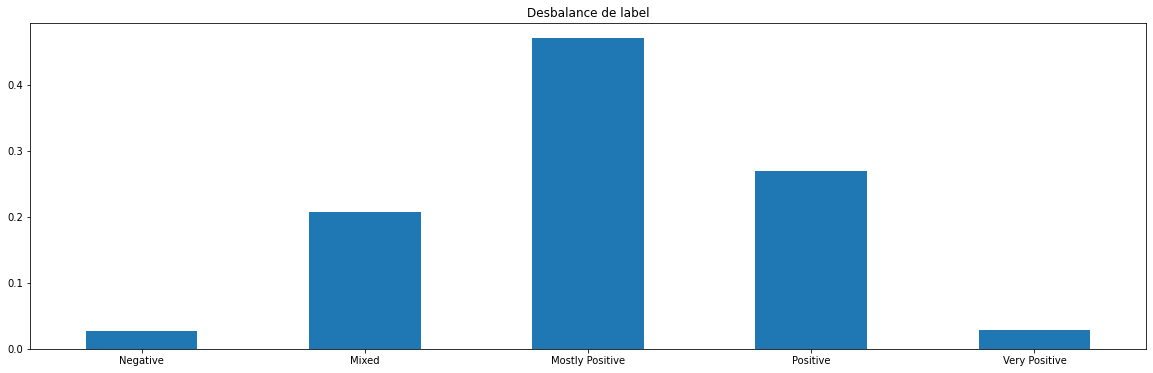

In [24]:
df.label.value_counts(normalize=True,sort=False).plot(kind='bar',rot=0,figsize=(20,6),title='Desbalance de label');

In [25]:
print("Skewness: %f" % df.label.value_counts(normalize=True,sort=False).skew())
print("Kurtosis: %f" % df.label.value_counts(normalize=True,sort=False).kurt())

Skewness: 0.636957
Kurtosis: -0.445988


In [26]:
# Vemos los valores únicos por cada columna.

print(df.apply(lambda col: len(col.unique())))

budget                   627
target                  5121
runtime                  146
status                     1
title                   5308
genres                  1384
original_language         30
overview                5308
production_companies    4587
release_date            3879
tagline                 4844
credits                 5308
keywords                5191
label                      5
dtype: int64


In [27]:
n_cols = 1

important = ['original_language','genres']

fig = make_subplots(
    rows=len(important) // n_cols + 1, cols=n_cols, subplot_titles=important
)

for idx, col in enumerate(important):
    row_idx = idx // n_cols + 1
    col_idx = idx % n_cols + 1

    data = df.loc[:, col]
    hist = go.Histogram(x=data, name=col,histnorm='probability')
    fig.add_trace(hist, row=row_idx, col=col_idx)

fig.update_layout(
    height=2000,
    title_text="Análisis Univariado de las Variables Categoricas",
    showlegend=False,
)
fig.show()

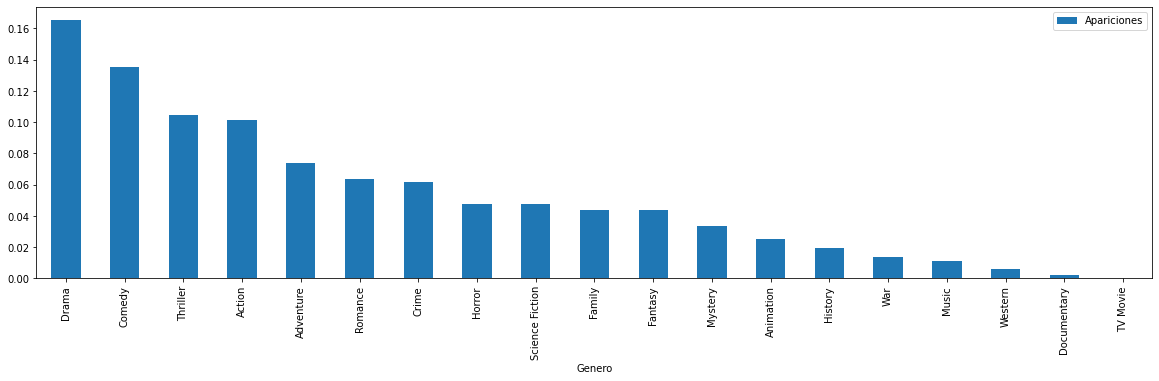

In [28]:
# Corrigiendo la superposición en genres

gen,apa = np.unique(df.genres.apply(lambda x: x.split('-')).sum(),return_counts=True)
generos = pd.DataFrame()
generos['Genero'] = gen
generos['Apariciones'] = apa/apa.sum()
generos = generos.sort_values(by='Apariciones',ascending=False)
generos = generos.set_index('Genero')
generos.plot(kind='bar',figsize=(20,5));

In [29]:
fig = px.scatter_matrix(
    df,
    dimensions=list(numeric)+['label','original_language'],
    height=1200,
    title="Análisis Bivariado",
)
fig.update_traces(diagonal_visible=False)
fig.show()

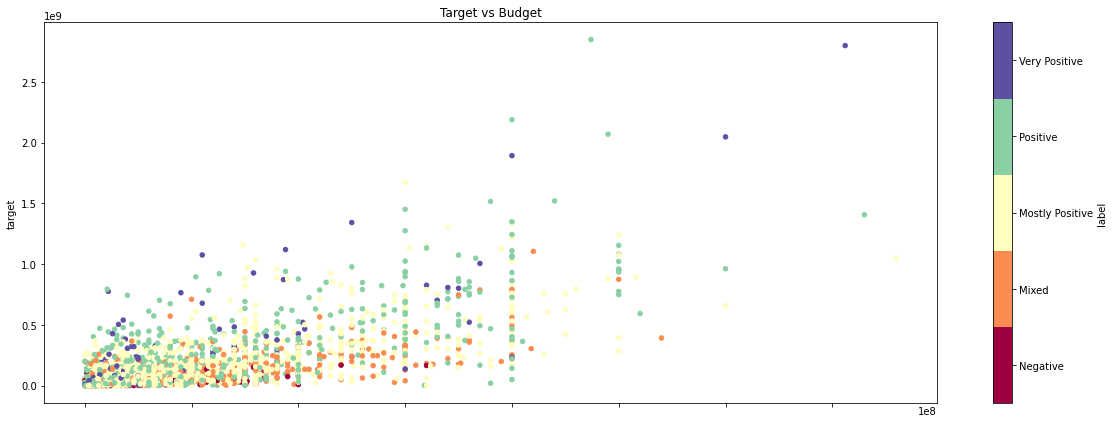

In [30]:
ax = df.plot.scatter(x='budget',y='target',c='label',colormap='Spectral',figsize=(20,7),title='Target vs Budget');

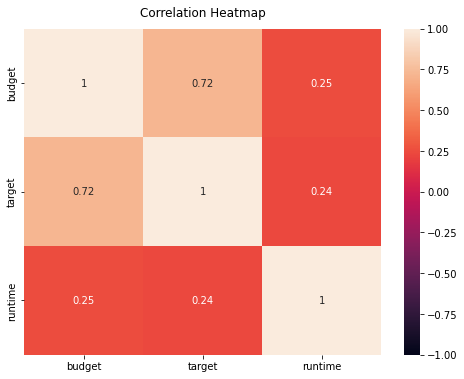

In [31]:
# Creamos la matriz de correlación de variables numéricas.

plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

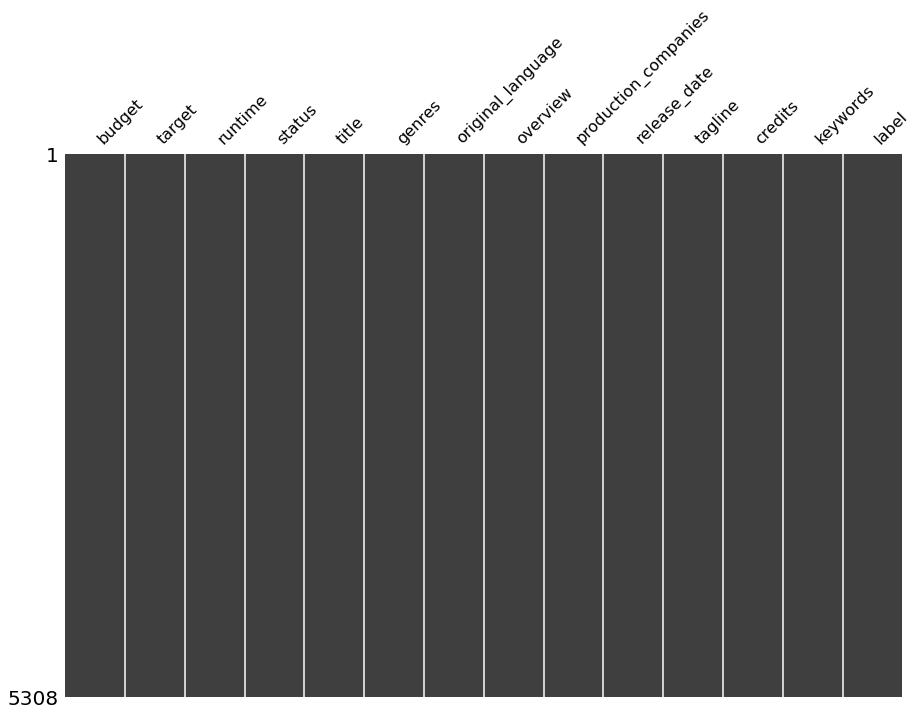

In [32]:
fig, ax = plt.subplots(figsize=[15, 10])

msno.matrix(df, ax=ax, sparkline=False);

In [33]:
df.isnull().sum().sort_values()

budget                  0
target                  0
runtime                 0
status                  0
title                   0
genres                  0
original_language       0
overview                0
production_companies    0
release_date            0
tagline                 0
credits                 0
keywords                0
label                   0
dtype: int64

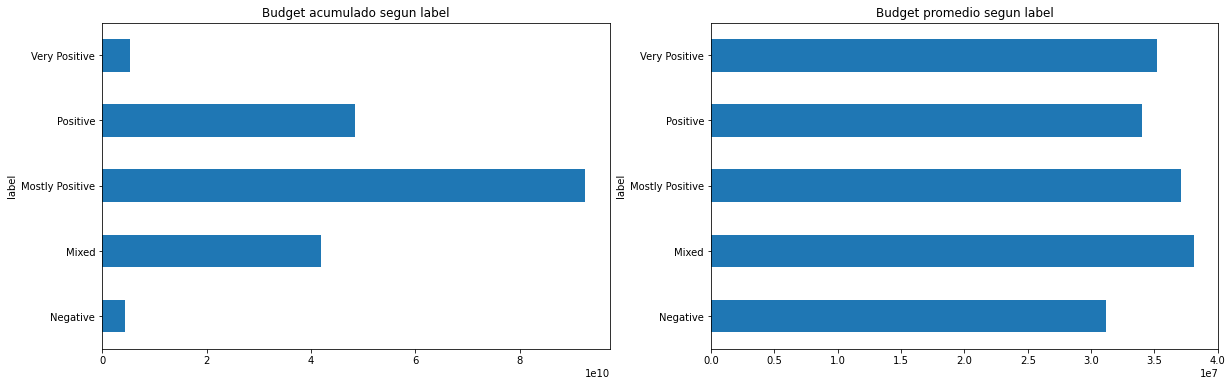

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(20,6))

df.groupby(['label']).sum().budget.plot(kind='barh',title='Budget acumulado segun label',ax=axes[0]);
df.groupby(['label']).mean().budget.plot(kind='barh',title='Budget promedio segun label',ax=axes[1]);

In [35]:
fig = px.line(df.sort_values(by='release_date'), x="release_date", y="budget",title='Evolución temporal de budget')
fig.show()

In [36]:
fig = px.parallel_categories(df.sample(1000).sort_values("target", ascending=False),dimensions=['original_language','label',],title = 'Categorías paralelas')
fig.show()

In [37]:
features = df.loc[:, ['budget','runtime', 'target']]

umap_2d = UMAP(n_components=2, init='random', random_state=0)
umap_3d = UMAP(n_components=3, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(features)
proj_3d = umap_3d.fit_transform(features)

fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=df.label, labels={'color': 'label'}
)
fig_3d = px.scatter_3d(
    proj_3d, x=0, y=1, z=2,
    color=df.label, labels={'color': 'label'}
)
fig_3d.update_traces(marker_size=5)

fig_2d.show();
fig_3d.show();

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning:

The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.



In [38]:
marvel = df[df['production_companies']=='Marvel Studios']
px.scatter(marvel, x='budget', y='target', hover_name='title', color=marvel.label, title= "Budget vs Target para películas de Marvel")

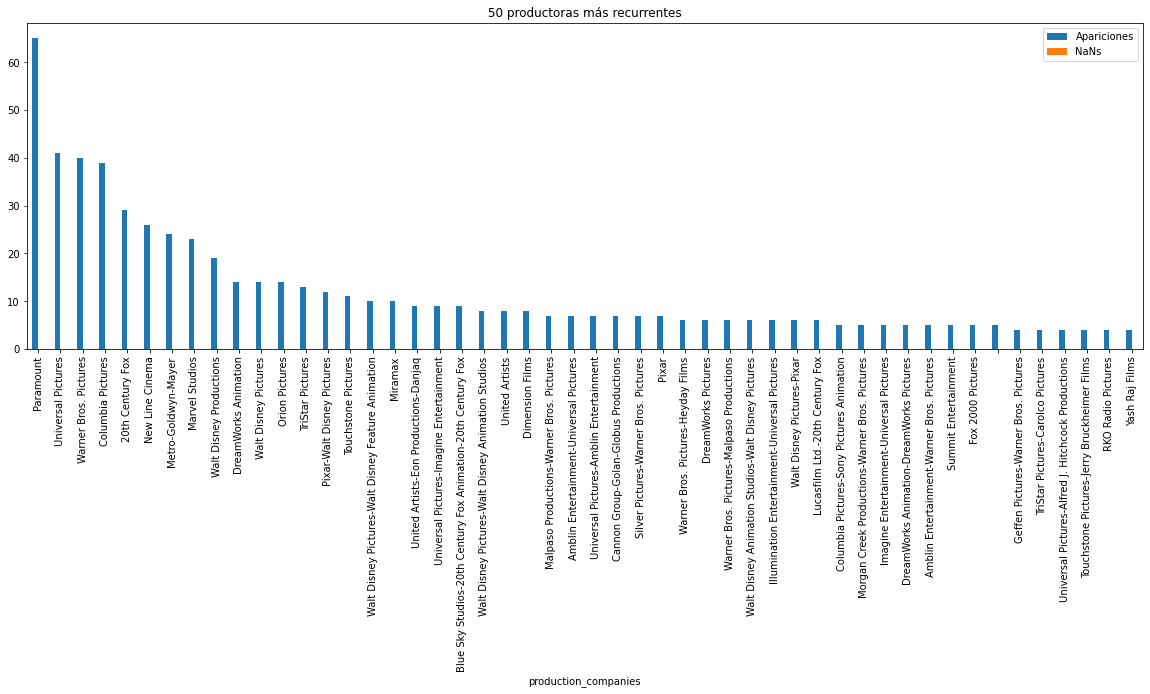

In [39]:
productoras = df['production_companies'].value_counts().iloc[0:50]
n_df = df.copy()
n_df['Apariciones'] = np.ones(len(df))
n_df['NaNs'] = df.isnull().sum(1)

prod = n_df.groupby('production_companies').sum().sort_values(by='Apariciones',ascending=False).head(50).loc[:,['Apariciones','NaNs']]

prod.plot(kind='bar',figsize=(20,6),title="50 productoras más recurrentes");

Existen 5970 productoras. 



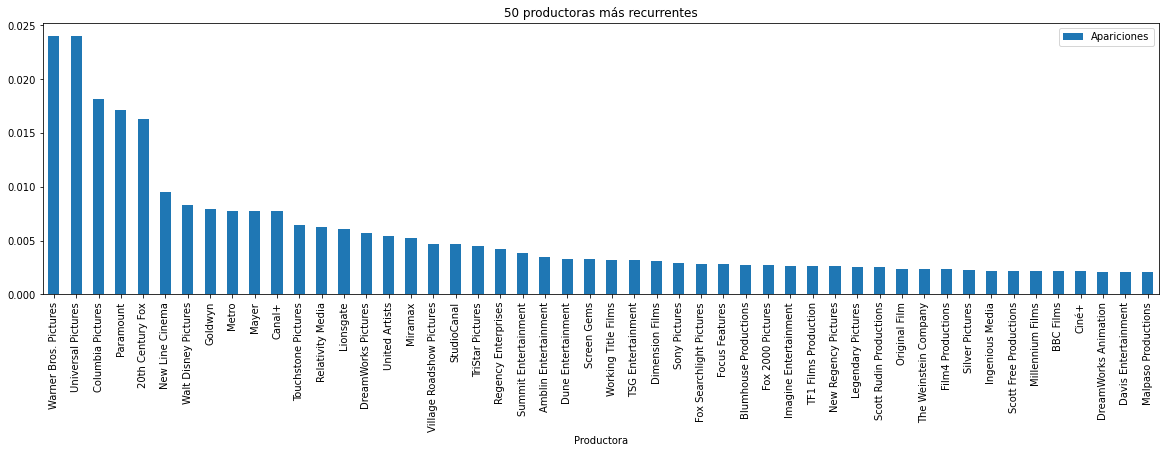

In [40]:
# Corrigiendo la superposición en production_companies

prod,apa = np.unique(df.production_companies.apply(lambda x: x.split('-')).sum(),return_counts=True)
productora = pd.DataFrame()
productora['Productora'] = prod
productora['Apariciones'] = apa/apa.sum()
productora = productora.sort_values(by='Apariciones',ascending=False)
print('Existen',len(productora),'productoras.','\n')
productora = productora.head(50)
productora = productora.set_index('Productora')
productora.plot(kind='bar',figsize=(20,5),title="50 productoras más recurrentes");

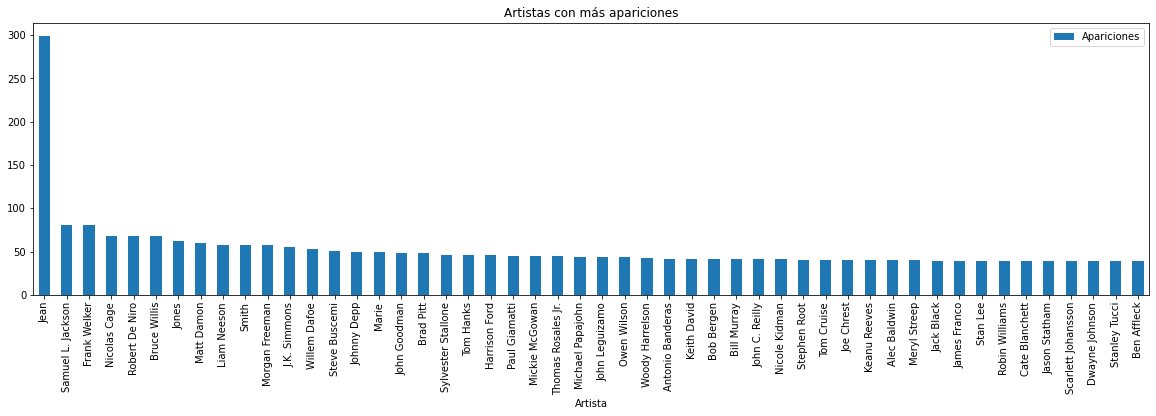

In [41]:
art,apa = np.unique(df.credits.apply(lambda x: x.split('-')).sum(),return_counts=True)
artistas = pd.DataFrame()
artistas['Artista'] = art
artistas['Apariciones'] = apa
artistas = artistas.sort_values(by='Apariciones',ascending=False).head(50)
artistas = artistas.set_index('Artista')
artistas.plot(kind='bar',figsize=(20,5),title='Artistas con más apariciones');

Se eliminan nombres de actores que no tengan apellidos.

In [42]:
def verificar(x):
  if ' ' in x:
    return x
  else:
    return np.nan

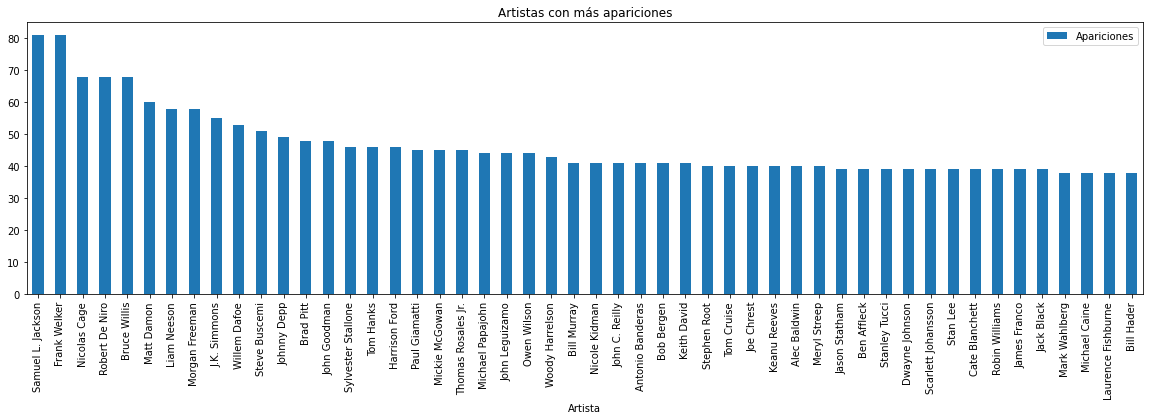

In [43]:
art,apa = np.unique(df.credits.apply(lambda x: x.split('-')).sum(),return_counts=True)
artistas = pd.DataFrame()
artistas['Artista'] = art
artistas['Apariciones'] = apa
artistas = artistas.sort_values(by='Apariciones',ascending=False)
artistas.Artista = artistas.Artista.apply(lambda x: verificar(x.strip()))
artistas = artistas.dropna(how='any')
artistas = artistas.sort_values(by='Apariciones',ascending=False).head(50)
artistas = artistas.set_index('Artista')
artistas.plot(kind='bar',figsize=(20,5),title='Artistas con más apariciones');

In [44]:
def preparar(texto):
  texto = re.sub('\,|\.',' ',texto)
  texto = re.sub('[^\s\w]','',texto)
  return re.sub('\s+',' ',texto).strip().lower()

In [45]:
def verificar2(x):
  if not x in stopwords.words('english')+['']:
    return x
  else:
    return np.nan

Existen 22931 palabras claves 



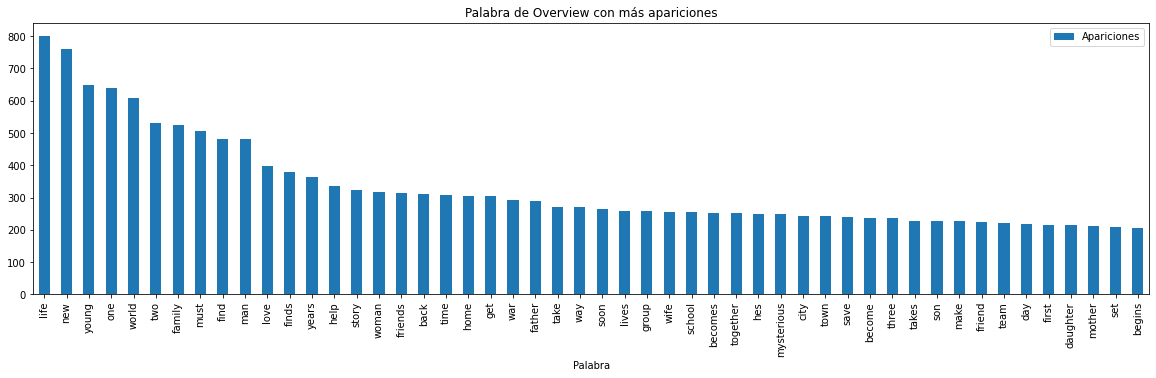

In [46]:
pal,apa = np.unique(df.overview.apply(lambda x: (preparar(x)).split(' ')).sum(),return_counts=True)
palabras = pd.DataFrame()
palabras['Palabra'] = pal
palabras['Apariciones'] = apa
palabras.Palabra = palabras.Palabra.apply(lambda x: verificar2(x.strip()))
palabras = palabras.dropna(how='any')
palabras = palabras.sort_values(by='Apariciones',ascending=False)
print('Existen',len(palabras),'palabras claves \n')
palabras = palabras.head(50)
palabras = palabras.set_index('Palabra')
palabras.plot(kind='bar',figsize=(20,5),title='Palabra de Overview con más apariciones');

Existen 4527 palabras claves 



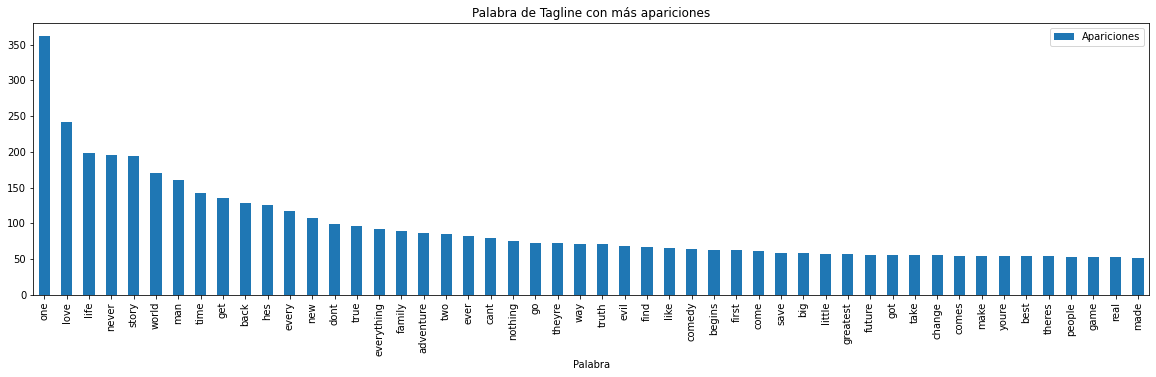

In [47]:
pal,apa = np.unique(df.tagline.apply(lambda x: (preparar(x)).split(' ')).sum(),return_counts=True)
palabras = pd.DataFrame()
palabras['Palabra'] = pal
palabras['Apariciones'] = apa
palabras.Palabra = palabras.Palabra.apply(lambda x: verificar2(x.strip()))
palabras = palabras.dropna(how='any')
palabras = palabras.sort_values(by='Apariciones',ascending=False)
print('Existen',len(palabras),'palabras claves \n')
palabras = palabras.head(50)
palabras = palabras.set_index('Palabra')
palabras.plot(kind='bar',figsize=(20,5),title='Palabra de Tagline con más apariciones');

Existen 4826 palabras claves 



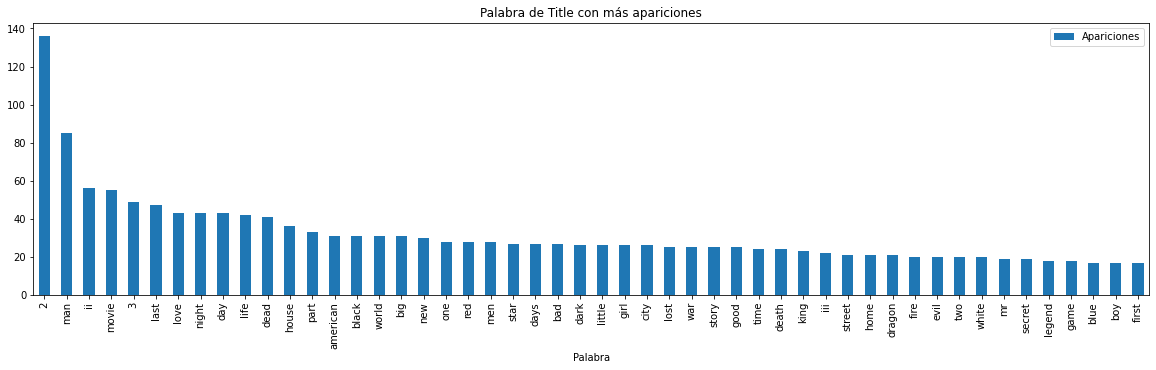

In [48]:
pal,apa = np.unique(df.title.apply(lambda x: (preparar(x)).split(' ')).sum(),return_counts=True)
palabras = pd.DataFrame()
palabras['Palabra'] = pal
palabras['Apariciones'] = apa
palabras.Palabra = palabras.Palabra.apply(lambda x: verificar2(x.strip()))
palabras = palabras.dropna(how='any')
palabras = palabras.sort_values(by='Apariciones',ascending=False)
print('Existen',len(palabras),'palabras claves \n')
palabras = palabras.head(50)
palabras = palabras.set_index('Palabra')
palabras.plot(kind='bar',figsize=(20,5),title='Palabra de Title con más apariciones');

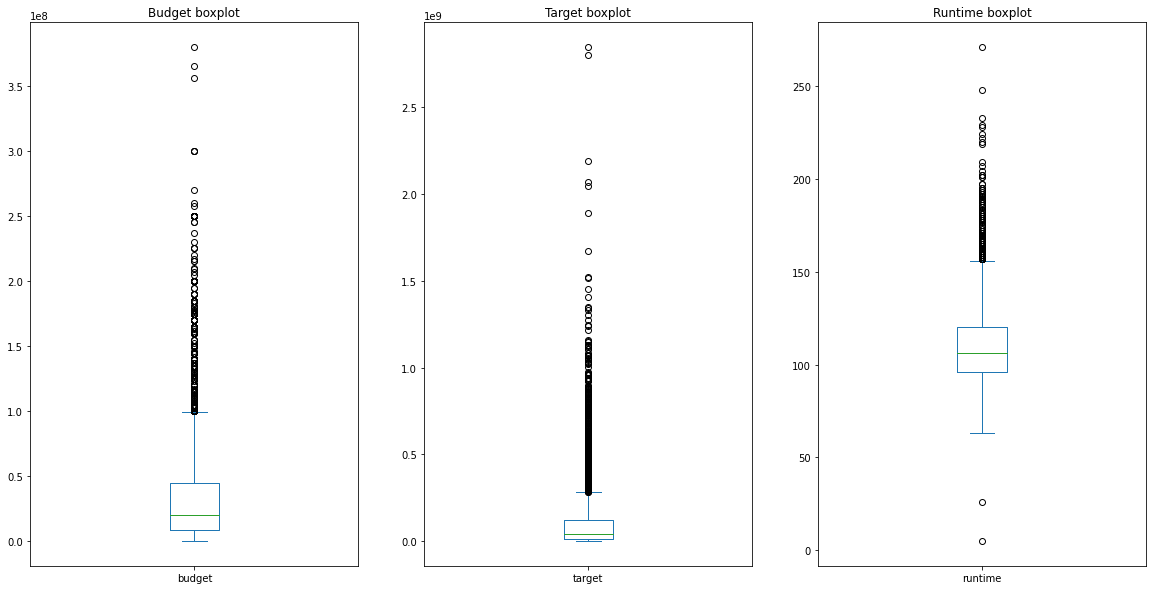

In [49]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20,6))

df.budget.plot(kind='box',figsize=(20,10),title='Budget boxplot',ax=axes[0]);
df.target.plot(kind='box',figsize=(20,10),title='Target boxplot',ax=axes[1]);
df.runtime.plot(kind='box',figsize=(20,10),title='Runtime boxplot',ax=axes[2]);

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5308 entries, 0 to 6450
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   budget                5308 non-null   float64       
 1   target                5308 non-null   float64       
 2   runtime               5308 non-null   float64       
 3   status                5308 non-null   object        
 4   title                 5308 non-null   object        
 5   genres                5308 non-null   object        
 6   original_language     5308 non-null   object        
 7   overview              5308 non-null   object        
 8   production_companies  5308 non-null   object        
 9   release_date          5308 non-null   datetime64[ns]
 10  tagline               5308 non-null   object        
 11  credits               5308 non-null   object        
 12  keywords              5308 non-null   object        
 13  label             

### Análisis del EDA

Nos se presentan valores nulos ni duplicados en el dataset luego de preparar los datos.

Las columnas "budget", "target" y "runtime" son numéricas. Las columnas "status", "title", "genres", "original_language", "overview", "production_companies", "tagline", "credits" y "keywords" contienen strings. La columna "realease_date" es de tipo tiempo de pandas. La columna "label" es categórica.

El dataset utiliza 661.8 KB de memoria.

Como se aprecia en la descripción numérica, se tienen películas con gasto igual a 0, además hay películas con ganancias mínimas de 1 dolar, lo cual no tiene sentido. A su vez, existen películas con tiempos de minutos.

Explorando las películas con duración menor a 30 minutos, se tiene que corresponden a cortometrajes. A su vez, poniendo un límite mínimo de 10.000 dólares para "budget" y "target" y buscando la información en internet de dichas películas, se tiene que dichos valores son erroneos, por lo que serán filtrados.

Por otra parte, respecto al análisis univariado se tiene que para "budget" aproximadamente el 15% de las películas están en el rango de [0 a 5M], disminuyendo exponencialmente la cantidad de películas a medida que aumenta el gasto. Para target aproximadamente el 30% de las películas están en el rango de [0 a 20M], disminuyendo exponencialmente la cantidad de películas a medida que aumentan las ganancias. Finalmente, para runtime se tiene que distribuye de manera normal, centrado en 100 minutos, con una asimetría hacia la izquierda (con skewness positivo igual a 1,383) y leptocúrtica (kurtosis positiva igual a 6,536).

Analizando el histograma de label se tiene un gran desbalance de clases. Esta variable distribuye normal, con una muy leve asimetría
hacia la izquierda (skewness positivo igual a 0,637) y de curva platicúrtica (kurtosis negativa igual a -0,446). De este modo, aproximadamente
el 50% de los datos son de la clase "Mostly Positive", el 25% son "Positive", el 20% son "Mixed" y tanto "Negative" como "Very Positive"
poseen alrededor del 2,5% de los datos cada uno.

Al visualizar los valores únicos de cada columna, se tiene que las columnas "genres", "credists" y "keywords" poseen muchos valores únicos ya que continen información solapada, es decir, muchas de ellas continen partes iguales, pero no la totalidad de los datos. Por ejemplo, en genres existe la categoría "Drama" y "Drama-War".

Respecto al análisis univariado de "original_language" se puede apreciar que la gran mayoría (aproximadamente el 90%) de las películas poseen idioma original en inglés. A su vez, para "genres" los géneros "Drama" y "Comedy" son los más recurrentes, pero se debe considerar que esta información sesgada por la superposición de datos antes mencionada. Esto se corrigió separando los géneros de todas la películas y calculando un nuevo histograma, donde se puede apreciar que en realidad son 19 géneros, siendo el más frecuente "Drama" (con aproximadamente 16% de las películas), seguidos de "Comedy" (14%), "Thriller" (10%), "Action" (10%) y "Romance" (6%).

Respecto al análisis bivariado, se observa una proporcionalidad directa entre budget y target. A su vez, en general las películas que no son
en idioma original inglés poseen menores gastos. Por otra parte, en general se aprecia un balance entre las clases de label respecto a las distintas
variables, es decir, no se presentan mayores valores de un label en específico para un solo idioma, o intervalo de gasto o ganancia. Ampliando el
scatter de targer vs budget, no es posible distinguir zonas específicas asignadas a un label.

Observando la matriz de correlación se aprecia una gran correlación positiva entre target y budget, lo que confirma nuestro análisis obtenido del
scatter. A su vez, se presentan bajas correlaciones positivas entre runtime y target, y entre runtime y budget.

Se según los gráficos de barras de budget acumulado por label y target promedio por label, se tiene que en total se ha invertido muchísimo más en
la clase "Mostly Positive", lo cual se explica dado el desbalance de estas clases. A su vez, se tiene que en promedio se ha invertido la misma cantidad
para todos los labels.

Respecto a la evoluación temporal de budget, se tiene que desde 1980 el gasto en películas comienza a crecer exponencialmente, llegando a valores máximos
en la década del 2010.

Por otra parte, en el gráfico de categorías paralelas se hace visible el gran aporte de las películas en inglés hacia las categorías de label, donde
este idioma aporta la mayoría de datos para todas las clases.

Al realizar la reducción de dimensionalidad mediante UMAP tanto en 2D como en 3D, no se encuentran estructuras representables.

Respecto a las películas de Marvel, estas se categorizan solamente entre los labels "Positive", "Mostly Positive" y "Very Positive", por lo que se
puede concluir que dicha productora es muy rentable. A su vez, se presenta nuevamente la relación directamente proporcional entre budget y target,
destacando que a mayor inversión también se recaudó más de manera proporcional, ya que en los mayores gastos se encuentran solamente películas con
label "Very Positive" y "Positive". Finalmente, la película que más recaudó (y la segunda en gastos) fue "Avengers: Endgame".

Inicialmente se realizó un gráfico de barras de las 50 productoras con más películas, pero existían errores ya que estaba la productora sin nombre
y existía superposición de datos (más de una productora por película). Sin corregir estos problemas, la mayor productora era "Paramount". Luego de
corregir, las mayores productoras son "Warner Bros. Pictures" y "Universal Pictures" (ambas con el 2,5% de las películas del mercado), seguidas de
"Columbia Pictures" (1,8%), "Paramount" (1,7%) y "20th Century Fox" (1,6%).

Similar al caso anterior, se realizó un gráfico de barras de los 50 actores con más apariciones en películas, pero existían errores ya que al momento
de separar los nombre, los apellidos compuestos por guión generaban nuevos actores con solamente el nombre. De este modo, sin corregir los errores
anteriores, el actor con más apariciones es "Jean", lo cual claramente es un error, además de que dentro del top 50 se encuentran actores como "Jones",
"Smith" y "Marie". Al corregir dichos errores (filtrando los actores que no tienen al menos un apellido), los actores con más apariciones son
"Samuel L. Jackson" y "Frank Welker" (ambos con 80 apariciones), seguidos de "Nicolas Cage", "Robert De Niro" y "Bruce Willis" (todos con 68 apariciones).

Se realizó una tokenización básica de los strings almacenados en la columna overview, donde se eliminaron las stopwords en inglés de la librería
NLTK (ya que a pesar del idioma original de la película, todos los datos están escritos en inglés). De este modo, se tiene que las palabras con más
apariciones en overview son "life", "new", "young", "one" y "world". Del mismo modo, al realizar la tokenización en tagline, las palabras más
recurrentes son "one", "love", "life", "never" y "story". Finalmente, para title las palabras más recurrentes son "2", "man", "ii", "movie" y "3".

Respecto al boxplot de variables numéricas, se tiene que tanto budget, target y runtime presentan una gran cantidad de valores outliers por sobre la media,
A su vez, runtime presenta unos pocos valores outliers bajo la media.

Finalmente, el dataset se compone de 5308 filas, sin valores nulos. Se compone de 3 columnas numéricas, una columna de fechas, 9 de strings y 1 categórica,
utilizando un total de 586 KB de memoria.

---

## 3. Preprocesamiento, Holdout y Feature Engineering

Para las columnas "title", "keywors", "overview", "genres" y "tagline" se realizó la siguiente transformación:



*   Se separaron los elementos superpuestos.
*   Se juntaron todos los elementos de todas las filas en un solo vector.
*   Se calculó un ponderador de concurrencia normalizado. De este modo, las palabras/elementos más comunes poseen mayor valor.
*   Se calcula el valor de una fila como la suma de los valores de cada uno de sus elementos.

De este modo, se está imponiendo que los elementos más comunes deberían ponderar más, ya que significaría que es un mercado muy poblado y por ende rentable.

Por otra parte, para feature engineering se crear las columnas de:

1.   Cantidad de actores
2.   Cantidad de géneros de la película
3.   Cantidad de productoras que crearon la película
4.   Ratio gasto/cantidad de actores
5.   Ratio duración de película/cantidad de actores





### Columns transformers

#### Credits

In [152]:
def verificar(x):
  if ' ' in x:
    return x.lower()
  else:
    return np.nan

art,apa = np.unique(df.credits.apply(lambda x: x.split('-')).sum(),return_counts=True)
artistas = pd.DataFrame()
artistas['Artista'] = art
artistas['Apariciones'] = apa/apa.sum()
artistas = artistas.sort_values(by='Apariciones',ascending=False)
artistas.Artista = artistas.Artista.apply(lambda x: verificar(x.strip()))
artistas = artistas.dropna(how='any')
artistas = artistas.sort_values(by='Apariciones',ascending=False)
dic = dict(zip(artistas.to_numpy()[:,0], artistas.to_numpy()[:,1]))

In [153]:
def actorizar(string):
  art = string.split('-')
  artistas = pd.DataFrame()
  artistas['Artista'] = art
  artistas.Artista = artistas.Artista.apply(lambda x: verificar(x.strip()))
  artistas = artistas.dropna(how='any')
  artistas = artistas.Artista.map(dic)
  artistas = artistas.dropna(how='any')
  if len(artistas)==0:
    return 0
  else:
    return artistas.sum()/len(artistas)

In [154]:
def act(X,y=None):
    X = pd.DataFrame(X,columns=['credits'])
    return pd.DataFrame(X.credits.apply(actorizar))

#### Production_companies


In [155]:
prod,apa = np.unique(df.production_companies.apply(lambda x: x.split('-')).sum(),return_counts=True)
productora = pd.DataFrame()
productora['Productora'] = prod
productora['Apariciones'] = apa/apa.sum()
productora = productora.sort_values(by='Apariciones',ascending=False)
dic2 = dict(zip(productora.to_numpy()[:,0], productora.to_numpy()[:,1]))

In [156]:
def productora(string):
  datos = string.split('-')
  data = pd.DataFrame()
  data['Col'] = datos
  data.Col = data.Col.apply(lambda x: x.strip())
  data = data.Col.map(dic2)
  data = data.dropna(how='any')
  if len(data)==0:
    return 0
  else:
    return data.sum()/len(data)

In [157]:
def prod(X,y=None):
  X = pd.DataFrame(X,columns=['production_companies'])
  return pd.DataFrame(X.production_companies.apply(productora))

#### Title

In [158]:
pal,apa = np.unique(df.title.apply(lambda x: (preparar(x)).split(' ')).sum(),return_counts=True)
palabras = pd.DataFrame()
palabras['Palabra'] = pal
palabras['Apariciones'] = apa
palabras.Palabra = palabras.Palabra.apply(lambda x: verificar2(x.strip()))
palabras = palabras.dropna(how='any')
palabras = palabras.sort_values(by='Apariciones',ascending=False).head(100)
palabras.Apariciones = palabras.Apariciones/palabras.Apariciones.sum()
dic3 = dict(zip(palabras.to_numpy()[:,0], palabras.to_numpy()[:,1]))

In [159]:
def titular(string):
  datos = string.split(' ')
  data = pd.DataFrame()
  data['Col'] = datos
  data.Col = data.Col.apply(lambda x: x.strip())
  data = data.Col.map(dic3)
  data = data.dropna(how='any')
  if len(data)==0:
    return 0
  else:
    return data.sum()/len(data)

In [160]:
def tit(X,y=None):
  X = pd.DataFrame(X,columns=['title'])
  return pd.DataFrame(X.title.apply(titular))

#### Overview

In [161]:
pal,apa = np.unique(df.overview.apply(lambda x: (preparar(x)).split(' ')).sum(),return_counts=True)
palabras = pd.DataFrame()
palabras['Palabra'] = pal
palabras['Apariciones'] = apa
palabras.Palabra = palabras.Palabra.apply(lambda x: verificar2(x.strip()))
palabras = palabras.dropna(how='any')
palabras = palabras.sort_values(by='Apariciones',ascending=False).head(100)
palabras.Apariciones = palabras.Apariciones/palabras.Apariciones.sum()
dic4 = dict(zip(palabras.to_numpy()[:,0], palabras.to_numpy()[:,1]))

In [162]:
def overview(string):
  datos = string.split(' ')
  data = pd.DataFrame()
  data['Col'] = datos
  data.Col = data.Col.apply(lambda x: x.strip())
  data = data.Col.map(dic4)
  data = data.dropna(how='any')
  if len(data)==0:
    return 0
  else:
    return data.sum()/len(data)

In [163]:
def ove(X,y=None):
  X = pd.DataFrame(X,columns=['overview'])
  return pd.DataFrame(X.overview.apply(overview))

#### Tagline

In [164]:
pal,apa = np.unique(df.tagline.apply(lambda x: (preparar(x)).split(' ')).sum(),return_counts=True)
palabras = pd.DataFrame()
palabras['Palabra'] = pal
palabras['Apariciones'] = apa
palabras.Palabra = palabras.Palabra.apply(lambda x: verificar2(x.strip()))
palabras = palabras.dropna(how='any')
palabras = palabras.sort_values(by='Apariciones',ascending=False).head(100)
palabras.Apariciones = palabras.Apariciones/palabras.Apariciones.sum()
dic5 = dict(zip(palabras.to_numpy()[:,0], palabras.to_numpy()[:,1]))

In [165]:
def tagline(string):
  datos = string.split(' ')
  data = pd.DataFrame()
  data['Col'] = datos
  data.Col = data.Col.apply(lambda x: x.strip())
  data = data.Col.map(dic5)
  data = data.dropna(how='any')
  if len(data)==0:
    return 0
  else:
    return data.sum()/len(data)

In [166]:
def tag(X,y=None):
  X = pd.DataFrame(X,columns=['tagline'])
  return pd.DataFrame(X.tagline.apply(tagline))

#### Keywords

In [167]:
def filtrar_vacios(x):
  if x == '':
    return np.nan
  else:
    return x.strip()

In [168]:
pal,apa = np.unique(df.keywords.apply(lambda x: ((x.lower()).split('-'))).sum(),return_counts=True)
palabras = pd.DataFrame()
palabras['Palabra'] = pal
palabras['Apariciones'] = apa
palabras.Palabra = palabras.Palabra.apply(filtrar_vacios)
palabras = palabras.dropna(how='any')
palabras = palabras.sort_values(by='Apariciones',ascending=False).head(100)
palabras.Apariciones = palabras.Apariciones/palabras.Apariciones.sum()
dic6 = dict(zip(palabras.to_numpy()[:,0], palabras.to_numpy()[:,1]))

In [169]:
def keywords(string):
  datos = string.split('-')
  data = pd.DataFrame()
  data['Col'] = datos
  data.Col = data.Col.apply(lambda x: x.strip())
  data = data.Col.map(dic6)
  data = data.dropna(how='any')
  if len(data)==0:
    return 0
  else:
    return data.sum()/len(data)

In [170]:
def key(X,y=None):
  X = pd.DataFrame(X,columns=['keywords'])
  return pd.DataFrame(X.keywords.apply(keywords))

#### Genres

In [171]:
gen,apa = np.unique(df.genres.apply(lambda x: x.split('-')).sum(),return_counts=True)
generos = pd.DataFrame()
generos['Genero'] = gen
generos['Apariciones'] = apa/apa.sum()
generos = generos.sort_values(by='Apariciones',ascending=False)
dic7 = dict(zip(generos.to_numpy()[:,0], generos.to_numpy()[:,1]))

In [172]:
def generizar(string):
  datos = string.split('-')
  data = pd.DataFrame()
  data['Col'] = datos
  data.Col = data.Col.apply(lambda x: x.strip())
  data = data.Col.map(dic7)
  data = data.dropna(how='any')
  if len(data)==0:
    return 0
  else:
    return data.sum()/len(data)

In [173]:
def gen(X,y=None):
  X = pd.DataFrame(X,columns=['genres'])
  return pd.DataFrame(X.genres.apply(generizar))

#### Original_language

In [174]:
idiomas = list(df.original_language.value_counts().index[:5])

def original_len(X,y=None):
  X = pd.DataFrame(X,columns=['original_language'])
  return pd.DataFrame(X.original_language.map(lambda x: x if x in idiomas else 'ot'))

### Drop columns

In [175]:
class columnDropperTransformer():
    def __init__(self,columns):
        self.columns=columns

    def transform(self,X,y=None):
        return X.drop(self.columns,axis=1)

    def fit(self, X, y=None):
        return self

### Imputer

In [176]:
numeric = ['budget','runtime']

### Holdout

In [177]:
## Código Holdout
X = df.drop(["target", "label"],axis=1)
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y, shuffle=True)

In [178]:
X_reg = df.drop(["target", "label"],axis=1)
y_reg = df["target"]

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=0, shuffle=True)

### Preprocesing

In [179]:
cred = Pipeline(steps=[("imputer_cat", SimpleImputer(strategy="most_frequent", fill_value="NA")),('Credits', FunctionTransformer(act))])
produ = Pipeline(steps=[("imputer_cat", SimpleImputer(strategy="most_frequent", fill_value="NA")),('Production', FunctionTransformer(prod))])
title = Pipeline(steps=[("imputer_cat", SimpleImputer(strategy="most_frequent", fill_value="NA")),('Title', FunctionTransformer(tit))])
over = Pipeline(steps=[("imputer_cat", SimpleImputer(strategy="most_frequent", fill_value="NA")),('Overview', FunctionTransformer(ove))])
tagli = Pipeline(steps=[("imputer_cat", SimpleImputer(strategy="most_frequent", fill_value="NA")),('Tagline', FunctionTransformer(tag))])
kwords = Pipeline(steps=[("imputer_cat", SimpleImputer(strategy="most_frequent", fill_value="NA")),('Keywords', FunctionTransformer(key))])
genr = Pipeline(steps=[("imputer_cat", SimpleImputer(strategy="most_frequent", fill_value="NA")),('Genres', FunctionTransformer(gen))])
o_len = Pipeline(steps=[("imputer_cat", SimpleImputer(strategy="most_frequent", fill_value="NA")),('Original', FunctionTransformer(original_len)),('OneHotEncoder', OneHotEncoder(sparse=False, handle_unknown="error"))])

In [180]:
## Código ColumnTransformer

preprocessing = ColumnTransformer(
    transformers=[
        ("imputer_num", KNNImputer(n_neighbors=2, weights="uniform"),numeric),
        ('Credits', cred, ['credits']),
        ('Production', produ, ['production_companies']),
        ('Title', title, ['title']),
        ('Overview', over, ['overview']),
        ('Tagline', tagli, ['tagline']),
        ('Keywords', kwords, ['keywords']),
        ('Genres', genr, ['genres']),
        ('Original', o_len, ['original_language']),
        ("MinMaxScaler",MinMaxScaler(),["budget"]),
        ('StandardScaler', StandardScaler(),["runtime"]),
        ],verbose=True)

### Feature Engineering

In [181]:
def contar_act(X,y=None):
  X = pd.DataFrame(data=list(X.credits),columns=['algo'])
  X["algo"] = list(X["algo"].str.split('-').str.len())
  return  pd.DataFrame(X.algo)

def contar_prod(X,y=None):
  X = pd.DataFrame(data=list(X.production_companies),columns=['algo'])
  X["algo"] = list(X["algo"].str.split('-').str.len())
  return  pd.DataFrame(X.algo)

def contar_gen(X,y=None):
  X = pd.DataFrame(data=list(X.genres),columns=['algo'])
  X["algo"] = list(X["algo"].str.split('-').str.len())
  return  pd.DataFrame(X.algo)

def ratios(df):
  contado = np.array(contar_act(pd.DataFrame(df.credits)).algo)
  gasto = np.array(df.budget)
  tiempo = np.array(df.runtime)
  X = pd.DataFrame()
  X['ratio_gasto'] = gasto/contado
  X['ratio_tiempo'] = tiempo/contado
  return X

In [182]:
nueva_1 = ColumnTransformer(transformers=[("contar_act",FunctionTransformer(contar_act),["credits"])])
nueva_2 = ColumnTransformer(transformers=[("contar_prod",FunctionTransformer(contar_prod),["production_companies"])])
nueva_3 = ColumnTransformer(transformers=[("contar_gen",FunctionTransformer(contar_gen),["genres"])])
nueva_4 = ColumnTransformer(transformers=[("ratio",FunctionTransformer(ratios),["runtime","budget","credits"])])

union = FeatureUnion([('preprocessing',preprocessing),('Contar_act', nueva_1),('Contar_prod', nueva_2),('Contar_gen', nueva_3),('Ratio', nueva_4)])

```
Comentarios
```

---

## 4. Clasificación


### 4.1 Dummy y Baseline

In [183]:
## Código Dummy

dummy_clf = DummyClassifier(strategy="stratified")

PL_dummy = Pipeline(steps=[("drop",columnDropperTransformer(['status','release_date'])),
                    ("preprocessing", preprocessing),
                    ("Dummy", dummy_clf)],verbose=True)

PL_dummy.fit(X_train, y_train)
y_pred_dummy = PL_dummy.predict(X_test)

[Pipeline] .............. (step 1 of 3) Processing drop, total=   0.0s
[ColumnTransformer] .. (1 of 11) Processing imputer_num, total=   0.0s
[ColumnTransformer] ...... (2 of 11) Processing Credits, total= 3.6min
[ColumnTransformer] ... (3 of 11) Processing Production, total=  17.6s
[ColumnTransformer] ........ (4 of 11) Processing Title, total=   9.3s
[ColumnTransformer] ..... (5 of 11) Processing Overview, total=  10.2s
[ColumnTransformer] ...... (6 of 11) Processing Tagline, total=   9.7s
[ColumnTransformer] ..... (7 of 11) Processing Keywords, total=   9.9s
[ColumnTransformer] ....... (8 of 11) Processing Genres, total=   9.8s
[ColumnTransformer] ..... (9 of 11) Processing Original, total=   0.0s
[ColumnTransformer]  (10 of 11) Processing MinMaxScaler, total=   0.0s
[ColumnTransformer]  (11 of 11) Processing StandardScaler, total=   0.0s
[Pipeline] ..... (step 2 of 3) Processing preprocessing, total= 4.7min
[Pipeline] ............. (step 3 of 3) Processing Dummy, total=   0.0s


In [184]:
## Código Clasificador

baseline_clf = GradientBoostingClassifier(n_estimators=150, learning_rate=1.0, random_state=0)

PL_baseline = Pipeline(steps=[("drop",columnDropperTransformer(['status','release_date'])),
                    ("preprocessing", preprocessing),
                    ("GradientBoosting", baseline_clf)],verbose=True)

PL_baseline.fit(X_train, y_train)
y_pred_baseline = PL_baseline.predict(X_test)

[Pipeline] .............. (step 1 of 3) Processing drop, total=   0.0s
[ColumnTransformer] .. (1 of 11) Processing imputer_num, total=   0.0s
[ColumnTransformer] ...... (2 of 11) Processing Credits, total= 3.8min
[ColumnTransformer] ... (3 of 11) Processing Production, total=  18.5s
[ColumnTransformer] ........ (4 of 11) Processing Title, total=   9.7s
[ColumnTransformer] ..... (5 of 11) Processing Overview, total=  11.0s
[ColumnTransformer] ...... (6 of 11) Processing Tagline, total=  11.3s
[ColumnTransformer] ..... (7 of 11) Processing Keywords, total=  10.1s
[ColumnTransformer] ....... (8 of 11) Processing Genres, total=   9.5s
[ColumnTransformer] ..... (9 of 11) Processing Original, total=   0.0s
[ColumnTransformer]  (10 of 11) Processing MinMaxScaler, total=   0.0s
[ColumnTransformer]  (11 of 11) Processing StandardScaler, total=   0.0s
[Pipeline] ..... (step 2 of 3) Processing preprocessing, total= 5.0min
[Pipeline] .. (step 3 of 3) Processing GradientBoosting, total=   8.8s


In [185]:
## Código Comparación de métricas
print('F1 modelo dummy',f1_score(y_test, y_pred_dummy, average='macro'))
print('F1 modelo baseline',f1_score(y_test, y_pred_baseline, average='macro'))

F1 modelo dummy 0.19088741367452727
F1 modelo baseline 0.31027249591575906


---

### 4.2 Búsqueda del mejor modelo de Clasificación


In [83]:
clf = RandomForestClassifier()

selection_pipeline_clf = Pipeline(steps=[("drop",columnDropperTransformer(['status','release_date'])),
                                         ('union', union),
                                         ("clf", clf),
                                         ],verbose=True)


gridParams_clf = [
    # grilla 1: LGBM 
    {
        "clf": [lgb.LGBMClassifier()],
        "clf__objective":["multiclass"],
        "clf__num_leaves": [15,50], # large num_leaves helps improve accuracy but might lead to over-fitting
        #"clf__max_depth": [10,20,None],
    },

    #grilla 2: RandomForest max_depth=None, criterion="entropy", n_estimators=200, max_features="auto"
    {
        "clf": [RandomForestClassifier()],
        "clf__max_depth": [6,12],
        "clf__criterion": ["gini", "entropy"],
        "clf__max_features": ['auto'],
        #"clf__min_samples_leaf": [1, 3],
        #"clf__min_samples_split": [2, 5],
        "clf__n_estimators": [200],
    },

    # grilla 3: XGBoost
    {
        "clf": [xg.XGBClassifier()],
        "clf__subsample":[0.5, 0.25],
        #"clf__colsample_bytree":[0.5, 0.25],
        #"clf__learning_rate":[0.1, 0.01],
        #"clf__min_child_weight ": [5, 15],
        "clf__eta": [0.01, 0.2],
        "clf__n_estimators":[100],
    }, 
]


grid_clf = GridSearchCV(selection_pipeline_clf, gridParams_clf, verbose=1, cv=2, n_jobs=None, scoring='f1_macro')

grid_clf.fit(X_train,y_train)
y_pred_clf = grid_clf.best_estimator_.predict(X_test)

print(f1_score(y_test, y_pred_clf, average='macro'))

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[Pipeline] .............. (step 1 of 3) Processing drop, total=   0.0s
[ColumnTransformer] .. (1 of 11) Processing imputer_num, total=   0.0s
[ColumnTransformer] ...... (2 of 11) Processing Credits, total= 1.7min
[ColumnTransformer] ... (3 of 11) Processing Production, total=   8.5s
[ColumnTransformer] ........ (4 of 11) Processing Title, total=   4.5s
[ColumnTransformer] ..... (5 of 11) Processing Overview, total=   4.9s
[ColumnTransformer] ...... (6 of 11) Processing Tagline, total=   4.7s
[ColumnTransformer] ..... (7 of 11) Processing Keywords, total=   4.9s
[ColumnTransformer] ....... (8 of 11) Processing Genres, total=   5.9s
[ColumnTransformer] ..... (9 of 11) Processing Original, total=   0.0s
[ColumnTransformer]  (10 of 11) Processing MinMaxScaler, total=   0.0s
[ColumnTransformer]  (11 of 11) Processing StandardScaler, total=   0.0s
[Pipeline] ............. (step 2 of 3) Processing union, total= 2.3min
[Pipeline] ...

In [84]:
### Código Predicción de datos de la competencia aquí

PL_mejor_clf = grid_clf.best_estimator_

In [85]:
print(PL_mejor_clf)

Pipeline(steps=[('drop',
                 <__main__.columnDropperTransformer object at 0x7f594e966f10>),
                ('union',
                 FeatureUnion(transformer_list=[('preprocessing',
                                                 ColumnTransformer(transformers=[('imputer_num',
                                                                                  KNNImputer(n_neighbors=2),
                                                                                  ['budget',
                                                                                   'runtime']),
                                                                                 ('Credits',
                                                                                  Pipeline(steps=[('imputer_cat',
                                                                                                   SimpleImputer(fill_value='NA',
                                                                       

---

## 5. Regresión

### 5.1 Dummy y Baseline

In [186]:
## Código Dummy

dummy_regr = DummyRegressor(strategy="mean")

PL_dummy_reg = Pipeline(steps=[("drop",columnDropperTransformer(['status','release_date'])),
                    ("preprocessing", preprocessing),
                    ("Dummy_reg", dummy_regr)],verbose=True)

PL_dummy_reg.fit(X_train_reg, y_train_reg)
y_pred_dummy_reg = PL_dummy_reg.predict(X_test_reg)

[Pipeline] .............. (step 1 of 3) Processing drop, total=   0.0s
[ColumnTransformer] .. (1 of 11) Processing imputer_num, total=   0.0s
[ColumnTransformer] ...... (2 of 11) Processing Credits, total= 3.2min
[ColumnTransformer] ... (3 of 11) Processing Production, total=  17.9s
[ColumnTransformer] ........ (4 of 11) Processing Title, total=   9.1s
[ColumnTransformer] ..... (5 of 11) Processing Overview, total=  11.2s
[ColumnTransformer] ...... (6 of 11) Processing Tagline, total=   9.6s
[ColumnTransformer] ..... (7 of 11) Processing Keywords, total=  10.2s
[ColumnTransformer] ....... (8 of 11) Processing Genres, total=  10.1s
[ColumnTransformer] ..... (9 of 11) Processing Original, total=   0.0s
[ColumnTransformer]  (10 of 11) Processing MinMaxScaler, total=   0.0s
[ColumnTransformer]  (11 of 11) Processing StandardScaler, total=   0.0s
[Pipeline] ..... (step 2 of 3) Processing preprocessing, total= 4.4min
[Pipeline] ......... (step 3 of 3) Processing Dummy_reg, total=   0.0s


In [187]:
## Código Regresor

baseline_reg = LinearRegression()

PL_baseline_reg = Pipeline(steps=[("drop",columnDropperTransformer(['status','release_date'])),
                    ("preprocessing", preprocessing),
                    ("Linear Regression", baseline_reg)],verbose=True)

PL_baseline_reg.fit(X_train_reg, y_train_reg)
y_pred_baseline_reg = PL_baseline_reg.predict(X_test_reg)

[Pipeline] .............. (step 1 of 3) Processing drop, total=   0.0s
[ColumnTransformer] .. (1 of 11) Processing imputer_num, total=   0.0s
[ColumnTransformer] ...... (2 of 11) Processing Credits, total= 3.2min
[ColumnTransformer] ... (3 of 11) Processing Production, total=  17.5s
[ColumnTransformer] ........ (4 of 11) Processing Title, total=   9.2s
[ColumnTransformer] ..... (5 of 11) Processing Overview, total=  10.2s
[ColumnTransformer] ...... (6 of 11) Processing Tagline, total=  10.4s
[ColumnTransformer] ..... (7 of 11) Processing Keywords, total=   9.9s
[ColumnTransformer] ....... (8 of 11) Processing Genres, total=   9.7s
[ColumnTransformer] ..... (9 of 11) Processing Original, total=   0.0s
[ColumnTransformer]  (10 of 11) Processing MinMaxScaler, total=   0.0s
[ColumnTransformer]  (11 of 11) Processing StandardScaler, total=   0.0s
[Pipeline] ..... (step 2 of 3) Processing preprocessing, total= 4.3min
[Pipeline] . (step 3 of 3) Processing Linear Regression, total=   0.0s


In [188]:
## Código Comparación de métricas
print('R2 modelo dummy_reg:', r2_score(y_test_reg, y_pred_dummy_reg))
print('R2 modelo baseline_reg:', r2_score(y_test_reg, y_pred_baseline_reg))

R2 modelo dummy_reg: -0.0008320257836642586
R2 modelo baseline_reg: 0.5391474157192728


---

### 5.2 Búsqueda del mejor modelo de Regresión


In [86]:
### Código GridSearch

reg = ensemble.GradientBoostingRegressor(n_estimators=150, learning_rate=1.0, random_state=0)

selection_pipeline_reg = Pipeline(steps=[("drop",columnDropperTransformer(['status','release_date'])),
                                         ('union', union),
                                         ("reg", reg),
                                         ],verbose=True)

gridParams_reg = [
    # grilla 1: LGBM Regressor
    {
        "reg": [lgb.LGBMRegressor()],
        'reg__learning_rate': [0.1, 0.03],
        #'reg__max_depth': [3, 5],
        'reg__n_estimators': [200],
    },

    #grilla 2: Linear Regression
    {
        "reg": [LinearRegression()],
    },

    # grilla 3: XGBoost Regressor
    {
        "reg": [xg.XGBRegressor()],
        'reg__learning_rate': [0.03, 0.05], #so called `eta` value
        #'reg__max_depth': [5, 7],
        'reg__min_child_weight': [4],
        'reg__silent': [1],
        'reg__subsample': [0.7],
        'reg__colsample_bytree': [0.7],
        'reg__n_estimators': [200,400]
    }, 

    #grilla 4: Gradient Boosting Regressor
    {
        "reg": [ensemble.GradientBoostingRegressor()],
        'reg__learning_rate': [0.1,0.01],
        #'reg__subsample'    : [0.2, 0.5],
        'reg__n_estimators' : [200],
        #'reg__max_depth'    : [4,8],
    }, 
]


grid_reg = GridSearchCV(selection_pipeline_reg, gridParams_reg, verbose=1, cv=2, n_jobs=None, scoring='r2')
grid_reg.fit(X_train_reg,y_train_reg)
y_pred_reg_grilla = grid_reg.best_estimator_.predict(X_test_reg)

print("r_2: %.2f" % r2_score(y_test_reg, y_pred_reg_grilla))

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[Pipeline] .............. (step 1 of 3) Processing drop, total=   0.0s
[ColumnTransformer] .. (1 of 11) Processing imputer_num, total=   0.0s
[ColumnTransformer] ...... (2 of 11) Processing Credits, total= 1.5min
[ColumnTransformer] ... (3 of 11) Processing Production, total=   9.9s
[ColumnTransformer] ........ (4 of 11) Processing Title, total=   4.5s
[ColumnTransformer] ..... (5 of 11) Processing Overview, total=   4.9s
[ColumnTransformer] ...... (6 of 11) Processing Tagline, total=   4.6s
[ColumnTransformer] ..... (7 of 11) Processing Keywords, total=   4.9s
[ColumnTransformer] ....... (8 of 11) Processing Genres, total=   4.7s
[ColumnTransformer] ..... (9 of 11) Processing Original, total=   0.0s
[ColumnTransformer]  (10 of 11) Processing MinMaxScaler, total=   0.0s
[ColumnTransformer]  (11 of 11) Processing StandardScaler, total=   0.0s
[Pipeline] ............. (step 2 of 3) Processing union, total= 2.1min
[Pipeline] ....

In [87]:
### Código Predicción de datos de la competencia aquí

PL_mejor_reg = grid_reg.best_estimator_

In [88]:
print(PL_mejor_reg)

Pipeline(steps=[('drop',
                 <__main__.columnDropperTransformer object at 0x7f594e4a6f10>),
                ('union',
                 FeatureUnion(transformer_list=[('preprocessing',
                                                 ColumnTransformer(transformers=[('imputer_num',
                                                                                  KNNImputer(n_neighbors=2),
                                                                                  ['budget',
                                                                                   'runtime']),
                                                                                 ('Credits',
                                                                                  Pipeline(steps=[('imputer_cat',
                                                                                                   SimpleImputer(fill_value='NA',
                                                                       

## Última mejora

### Características

#### Title

In [133]:
n_df = df.sort_values(by=['budget'],ascending=False).head(50)
pal,apa = np.unique(n_df.title.apply(lambda x: (preparar(x)).split(' ')).sum(),return_counts=True)
palabras = pd.DataFrame()
palabras['Palabra'] = pal
palabras['Apariciones'] = apa
palabras.Palabra = palabras.Palabra.apply(lambda x: verificar2(x.strip()))
palabras = palabras.dropna(how='any')
palabras = palabras.sort_values(by='Apariciones',ascending=False).head(100)
palabras.Apariciones = palabras.Apariciones/palabras.Apariciones.sum()
d3 = dict(zip(palabras.to_numpy()[:,0], palabras.to_numpy()[:,1]))

def titular(string):
  datos = string.split(' ')
  data = pd.DataFrame()
  data['Col'] = datos
  data.Col = data.Col.apply(lambda x: x.strip())
  data = data.Col.map(d3)
  data = data.dropna(how='any')
  if len(data)==0:
    return 0
  else:
    return data.sum()/len(data)

def tit(X,y=None):
  X = pd.DataFrame(X,columns=['title'])
  return pd.DataFrame(X.title.apply(titular))

#### Overview

In [134]:
n_df = df.sort_values(by=['budget'],ascending=False).head(50)
pal,apa = np.unique(n_df.overview.apply(lambda x: (preparar(x)).split(' ')).sum(),return_counts=True)
palabras = pd.DataFrame()
palabras['Palabra'] = pal
palabras['Apariciones'] = apa
palabras.Palabra = palabras.Palabra.apply(lambda x: verificar2(x.strip()))
palabras = palabras.dropna(how='any')
palabras = palabras.sort_values(by='Apariciones',ascending=False).head(100)
palabras.Apariciones = palabras.Apariciones/palabras.Apariciones.sum()
d4 = dict(zip(palabras.to_numpy()[:,0], palabras.to_numpy()[:,1]))

def overview(string):
  datos = string.split(' ')
  data = pd.DataFrame()
  data['Col'] = datos
  data.Col = data.Col.apply(lambda x: x.strip())
  data = data.Col.map(d4)
  data = data.dropna(how='any')
  if len(data)==0:
    return 0
  else:
    return data.sum()/len(data)

def ove(X,y=None):
  X = pd.DataFrame(X,columns=['overview'])
  return pd.DataFrame(X.overview.apply(overview))

#### Tagline

In [135]:
n_df = df.sort_values(by=['budget'],ascending=False).head(50)
pal,apa = np.unique(n_df.tagline.apply(lambda x: (preparar(x)).split(' ')).sum(),return_counts=True)
palabras = pd.DataFrame()
palabras['Palabra'] = pal
palabras['Apariciones'] = apa
palabras.Palabra = palabras.Palabra.apply(lambda x: verificar2(x.strip()))
palabras = palabras.dropna(how='any')
palabras = palabras.sort_values(by='Apariciones',ascending=False).head(100)
palabras.Apariciones = palabras.Apariciones/palabras.Apariciones.sum()
dic5 = dict(zip(palabras.to_numpy()[:,0], palabras.to_numpy()[:,1]))

def tagline(string):
  datos = string.split(' ')
  data = pd.DataFrame()
  data['Col'] = datos
  data.Col = data.Col.apply(lambda x: x.strip())
  data = data.Col.map(dic5)
  data = data.dropna(how='any')
  if len(data)==0:
    return 0
  else:
    return data.sum()/len(data)

def tag(X,y=None):
  X = pd.DataFrame(X,columns=['tagline'])
  return pd.DataFrame(X.tagline.apply(tagline))

#### Keywords

In [136]:
n_df = df.sort_values(by=['budget'],ascending=False).head(50)
pal,apa = np.unique(n_df.keywords.apply(lambda x: ((x.lower()).split('-'))).sum(),return_counts=True)
palabras = pd.DataFrame()
palabras['Palabra'] = pal
palabras['Apariciones'] = apa
palabras.Palabra = palabras.Palabra.apply(filtrar_vacios)
palabras = palabras.dropna(how='any')
palabras = palabras.sort_values(by='Apariciones',ascending=False).head(100)
palabras.Apariciones = palabras.Apariciones/palabras.Apariciones.sum()
d6 = dict(zip(palabras.to_numpy()[:,0], palabras.to_numpy()[:,1]))

def keywords(string):
  datos = string.split('-')
  data = pd.DataFrame()
  data['Col'] = datos
  data.Col = data.Col.apply(lambda x: x.strip())
  data = data.Col.map(d6)
  data = data.dropna(how='any')
  if len(data)==0:
    return 0
  else:
    return data.sum()/len(data)

#### Genres

In [137]:
n_df = df.sort_values(by=['budget'],ascending=False).head(50)
gen,apa = np.unique(n_df.genres.apply(lambda x: x.split('-')).sum(),return_counts=True)
generos = pd.DataFrame()
generos['Genero'] = gen
generos['Apariciones'] = apa/apa.sum()
generos = generos.sort_values(by='Apariciones',ascending=False)
d7 = dict(zip(generos.to_numpy()[:,0], generos.to_numpy()[:,1]))

def generizar(string):
  datos = string.split('-')
  data = pd.DataFrame()
  data['Col'] = datos
  data.Col = data.Col.apply(lambda x: x.strip())
  data = data.Col.map(d7)
  data = data.dropna(how='any')
  if len(data)==0:
    return 0
  else:
    return data.sum()/len(data)

def gen(X,y=None):
  X = pd.DataFrame(X,columns=['genres'])
  return pd.DataFrame(X.genres.apply(generizar))

### Pipelines

In [138]:
title = Pipeline(steps=[("imputer_cat", SimpleImputer(strategy="most_frequent", fill_value="NA")),('Title', FunctionTransformer(tit))])
over = Pipeline(steps=[("imputer_cat", SimpleImputer(strategy="most_frequent", fill_value="NA")),('Overview', FunctionTransformer(ove))])
tagli = Pipeline(steps=[("imputer_cat", SimpleImputer(strategy="most_frequent", fill_value="NA")),('Tagline', FunctionTransformer(tag))])
kwords = Pipeline(steps=[("imputer_cat", SimpleImputer(strategy="most_frequent", fill_value="NA")),('Keywords', FunctionTransformer(key))])
genr = Pipeline(steps=[("imputer_cat", SimpleImputer(strategy="most_frequent", fill_value="NA")),('Genres', FunctionTransformer(gen))])

In [139]:
preprocessing = ColumnTransformer(
    transformers=[
        ("imputer_num", KNNImputer(n_neighbors=2, weights="uniform"),numeric),
        ('Credits', cred, ['credits']),
        ('Production', produ, ['production_companies']),
        ('Title', title, ['title']),
        ('Overview', over, ['overview']),
        ('Tagline', tagli, ['tagline']),
        ('Keywords', kwords, ['keywords']),
        ('Genres', genr, ['genres']),
        ('Original', o_len, ['original_language']),
        ("MinMaxScaler",MinMaxScaler(),["budget"]),
        ('StandardScaler', StandardScaler(),["runtime"]),
        ],verbose=True)

union = FeatureUnion([('preprocessing',preprocessing),('Contar_act', nueva_1),('Contar_prod', nueva_2),('Contar_gen', nueva_3),('Ratio', nueva_4)])

In [141]:
pl_clf = Pipeline(steps=[("drop",columnDropperTransformer(['status','release_date'])),
                                         ('union', union),
                                         ("clf", lgb.LGBMClassifier(num_leaves=50, objective='multiclass')),
                                         ],verbose=True)

pl_reg = Pipeline(steps=[("drop",columnDropperTransformer(['status','release_date'])),
                                         ('union', union),
                                         ("clf", xg.XGBRegressor(colsample_bytree=0.7, learning_rate=0.03,
                                                              min_child_weight=4, n_estimators=200, silent=1,
                                                              subsample=0.7))],verbose=True)

### Entrenamiento y métricas

In [142]:
pl_clf.fit(X_train, y_train)
y_pred_ult = pl_clf.predict(X_test)

[Pipeline] .............. (step 1 of 3) Processing drop, total=   0.0s
[ColumnTransformer] .. (1 of 11) Processing imputer_num, total=   0.0s
[ColumnTransformer] ...... (2 of 11) Processing Credits, total= 3.8min
[ColumnTransformer] ... (3 of 11) Processing Production, total=  19.3s
[ColumnTransformer] ........ (4 of 11) Processing Title, total=   9.5s
[ColumnTransformer] ..... (5 of 11) Processing Overview, total=  10.1s
[ColumnTransformer] ...... (6 of 11) Processing Tagline, total=   9.4s
[ColumnTransformer] ..... (7 of 11) Processing Keywords, total=   9.8s
[ColumnTransformer] ....... (8 of 11) Processing Genres, total=   9.9s
[ColumnTransformer] ..... (9 of 11) Processing Original, total=   0.0s
[ColumnTransformer]  (10 of 11) Processing MinMaxScaler, total=   0.0s
[ColumnTransformer]  (11 of 11) Processing StandardScaler, total=   0.0s
[Pipeline] ............. (step 2 of 3) Processing union, total= 5.0min
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.6s


In [143]:
pl_reg.fit(X_train_reg, y_train_reg)
y_pred_ult_reg = pl_reg.predict(X_test_reg)

[Pipeline] .............. (step 1 of 3) Processing drop, total=   0.0s
[ColumnTransformer] .. (1 of 11) Processing imputer_num, total=   0.0s
[ColumnTransformer] ...... (2 of 11) Processing Credits, total= 3.3min
[ColumnTransformer] ... (3 of 11) Processing Production, total=  18.0s
[ColumnTransformer] ........ (4 of 11) Processing Title, total=   9.4s
[ColumnTransformer] ..... (5 of 11) Processing Overview, total=  10.6s
[ColumnTransformer] ...... (6 of 11) Processing Tagline, total=  10.6s
[ColumnTransformer] ..... (7 of 11) Processing Keywords, total=   9.9s
[ColumnTransformer] ....... (8 of 11) Processing Genres, total=   9.9s
[ColumnTransformer] ..... (9 of 11) Processing Original, total=   0.0s
[ColumnTransformer]  (10 of 11) Processing MinMaxScaler, total=   0.0s
[ColumnTransformer]  (11 of 11) Processing StandardScaler, total=   0.0s
[Pipeline] ............. (step 2 of 3) Processing union, total= 4.4min
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.7s


In [146]:
y_test_reg

1066     83282296.0
30      603873119.0
1778     17432163.0
4735     61279452.0
1927     27762648.0
           ...     
3202     12764201.0
6250    121550750.0
2974     43493123.0
5731    167184112.0
1967     69834815.0
Name: target, Length: 1062, dtype: float64

In [150]:
print('F1:',f1_score(y_test, y_pred_ult, average='macro'))
print('R2:', r2_score(y_test_reg, y_pred_ult_reg))

F1: 0.2982840080720758
R2: 0.5939088638381518


---

## 6. Conclusiones

Del presente informe se ve que se han completado exitosamente cada uno de los pasos que significa realizar un proyecto de Data Science con los conocimientos adquiridos durante el curso. Se realizaron las labores de preparación de datos, un análisis exploratorio de los datos, preprocesamiento, feature engineering y se realizaron los modelos de Clasificación y Regresión, ayudados de herramientas para el flujo de trabajo como lo son los Pipelines.

Del resultado de los mejores modelos en la competencia se tiene que están muy cerca de superar el baseline (en f1 a 0.1 y en r2 a 0.3 de superarlo), por lo que son modelos que podrían perfectamente ser funcionales. Por otro lado hay mucho margen de mejora, tanto en la selección de hiperparámetros como en la generación de características, por lo que se puede mejorar. Además el trabajo mediante Pipeline y la forma en la que está estructurado el proyecto permiten iterar fácilmente en estas mejoras.

En cuanto al EDA, este permitió comprender muchas cosas de los datos. Como ya se mencionó en su análisis, se trabajaron el formato de los mismos a partir de lo visto en el EDA. Por ejemplo, a partir del EDA se visualizó que era necesario separar entidades que estaban unidas por guiones como lo son los generos, que inicialmente al ser combinaciones de varios generos para cada película al contarlos parecían ser muchos, pero realmente sólo eran 19 géneros. O con respecto a los idiomas, donde el 90% de las películas se vió que eran en idioma ingles y más del 95% correspondia a sólo unos pocos idiomás más (inglés, español, frances, japonés). Cosas como estas ayudaron a trabajar de mejor manera los datos, a motivar crear ciertos rankings o bien a vectorizar textos según su relevancia en cuanto a la frecuencia que aparecian en las películas. Todo esto se vio reflejado en el preprocesamiento y el feature engineering, que repercutió positivamente tanto en el modelo de clasificación como de regresión.

Respecto a la clasificación no se pudo mejorar el rendimiento del baseline al utilizar el grid search en el conjunto de test generado al particionar los datos de entrenamiento, pero si mejoró el rendimiento en la competencia. El mejor modelo obtenido por el grid search utilizó un clasificador LGBMClassifier(num_leaves=50, objective='multiclass') junto con el preprocesamiento inicial y la creación de nuevas características.

Respecto a la regresión se pudo mejorar el rendimiento del baseline al utilizar el grid search en el conjunto de test generado al particionar los datos de entrenamiento de 0.53 a 0.59 en r2, además se mejoró el rendimiento en la competencia en gran medida. El mejor modelo obtenido por el grid search utilizó un regresor XGBRegressor(colsample_bytree=0.7, learning_rate=0.03, min_child_weight=4, n_estimators=200, silent=1, subsample=0.7) junto con el preprocesamiento inicial y la creación de nuevas características.

Cabe destacar que la sección "última mejora" corresponde a un nuevo enfoque en el tratamiento de las columnas "title", "keywors", "overview", "genres" y "tagline", donde solamente tienen valores mayores a 0, los objetos (dependiendo de la columna, palabras, generos, etc) pertenecientes a las 50 películas de mayor gasto. Este nuevo enfoque no obtuvo mejores métricas en ningún conjunto.

Finalmente, los resultados obtenidos estuvieron cerca de lo esperado. Cabe destacar que los mejores rendimientos en ambas métricas se obtuvieron mediante el uso de grid search, lo cual destaca su importancia. Por otra parte, el uso de pipelines es fundamental para un proyecto de Data Science, otorgando gran capacidad de versatilidad y modularización. Finalmente, el realizar un correcto análisis exploratorio de datos favorece el desarrollo del proyecto y el entendimiento del problema a resolver.


---

<br>

### Anexo: Generación de Archivo Submit de la Competencia

Para subir los resultados obtenidos a la pagina de CodaLab utilice la función `generateFiles` entregada mas abajo. Esto es debido a que usted deberá generar archivos que respeten extrictamente el formato de CodaLab, de lo contario los resultados no se veran reflejados en la pagina de la competencia.

Para los resultados obtenidos en su modelo de clasificación y regresión, estos serán guardados en un archivo zip que contenga los archivos `predicctions_clf.txt` para la clasificación y `predicctions_rgr.clf` para la regresión. Los resultados, como se comento antes, deberan ser obtenidos en base al dataset `test.pickle` y en cada una de las lineas deberan presentar las predicciones realizadas.

Ejemplos de archivos:

- [ ] `predicctions_clf.txt`

        Mostly Positive
        Mostly Positive
        Negative
        Positive
        Negative
        Positive
        ...

- [ ] `predicctions_rgr.txt`

        16103.58
        16103.58
        16041.89
        9328.62
        107976.03
        194374.08
        ...



In [ ]:
from zipfile import ZipFile
import os

def generateFiles(predict_data, clf_pipe, rgr_pipe):
    """Genera los archivos a subir en CodaLab

    Input
    predict_data: Dataframe con los datos de entrada a predecir
    clf_pipe: pipeline del clf
    rgr_pipe: pipeline del rgr

    Ouput
    archivo de txt
    """
    y_pred_clf = clf_pipe.predict(predict_data)
    y_pred_rgr = rgr_pipe.predict(predict_data)
    
    with open('./predictions_clf.txt', 'w') as f:
        for item in y_pred_clf:
            f.write("%s\n" % item)

    with open('./predictions_rgr.txt', 'w') as f:
        for item in y_pred_rgr:
            f.write("%s\n" % item)

    with ZipFile('predictions.zip', 'w') as zipObj2:
       zipObj2.write('predictions_rgr.txt')
       zipObj2.write('predictions_clf.txt')

    os.remove("predictions_rgr.txt")
    os.remove("predictions_clf.txt")

In [98]:
# Ejecutar función para generar el archivo de predicciones.
# perdict_data debe tener cargada los datos del text.pickle
# mientras que clf_pipe y rgr_pipe, son los pipeline de 
# clasificación y regresión respectivamente.
generateFiles(test, PL_mejor_clf, PL_mejor_reg)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>